# Decision Tree for Spotify Data

## Import Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the data in
data = pd.read_csv("./spotify_data.csv", index_col='Unnamed: 0')
print(data.shape)
print(data.info())
display(data.head())

(2017, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 2017 entries, 0 to 2016
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   float64
 12  valence           2017 non-null   float64
 13  target            2017 non-null   int64  
 14  song_title        2017 non-null   object 
 15  artist            2017 non-null   object 
dtypes: float64(10), int64(4), object(2)


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [3]:
# Check if there are any artists that are included more than once
data.groupby('artist')['target'].count().max()

16

In [4]:
# Check if all the song names are unique
len(data['song_title'].unique())

1956

#### Since the maximum number of times a singular artist is included is 16, which is less than 0.8% of the entire dataset, the artist column would probably not be a good feature to split on for a binary classification task. Additionally, since there are 1956 unique song titles in this dataset, the song_title column would not be a good feature to split on for this task either. Thus, these 2 columns will be dropped.

In [5]:
# Drop the song_title and artist columns and print the final list
data2 = data.drop(columns=['song_title','artist'])
print(data2.columns)

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target'],
      dtype='object')


In [6]:
from sklearn.feature_selection import mutual_info_classif

# Store the feature data in X and the label data in y
X = data2.drop(columns=['target'])
y = data2['target']

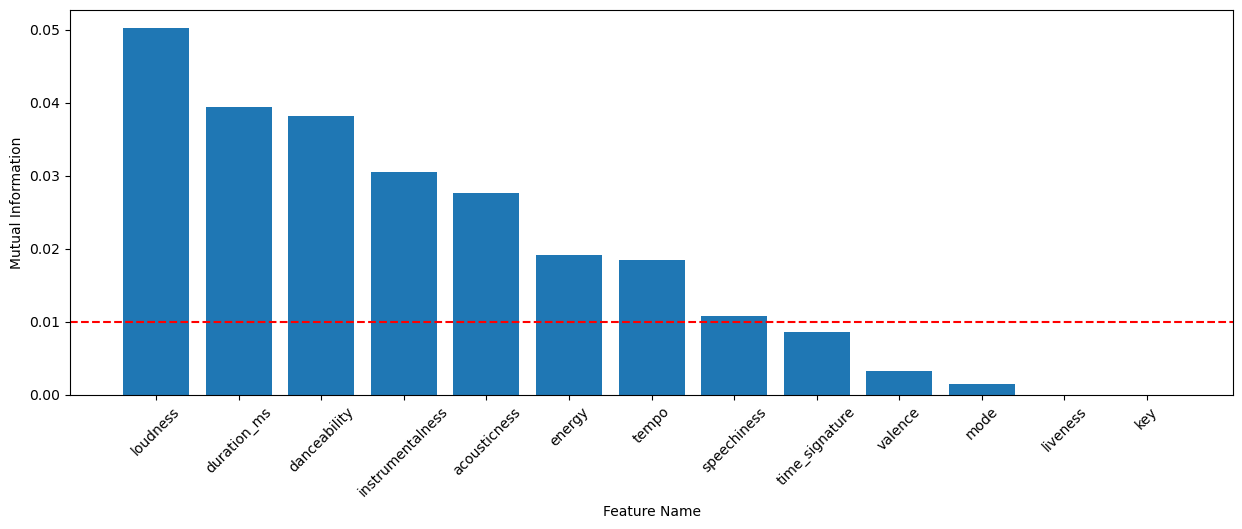

In [7]:
# Calculate mutual information
mutual_info = mutual_info_classif(X, y, random_state=6)

# Sort the features based on mutual information
feature_names = X.columns
sorted_idx = np.argsort(mutual_info)[::-1]
feature_names = [feature_names[i] for i in sorted_idx]
mutual_info = mutual_info[sorted_idx]

# Plot mutual information
plt.figure(figsize=(15,5))
plt.bar(np.arange(len(feature_names)),mutual_info)
plt.axhline(0.01, color='red', linestyle='--', label='Threshold')
plt.xticks(np.arange(len(feature_names)),labels=feature_names,rotation=45)
plt.xlabel('Feature Name')
plt.ylabel('Mutual Information')
plt.show()

#### To perform feature selection, I used mutual information as I thought it would be a good way to assess which features are most important and which ones are least important.Additionally, I thought it would be appropriate to use this metric as we are fitting decision trees to this data. Based on a threshold of mutual information = 0.01, The most important are loudness, duration_ms, danceability, instrumentalness, acousticness, energy, tempo, and speechiness while the least important features are time_signature, valence, mode, liveness, and key.

In [8]:
# Create a dataframe with just the useful features I have selected
newX = X[['loudness', 'duration_ms', 'danceability', 'instrumentalness', 'acousticness', 'energy', 'tempo', 'speechiness']]
print(newX.shape)
display(newX.head())

(2017, 8)


,loudness,duration_ms,danceability,instrumentalness,acousticness,energy,tempo,speechiness
0,-8.795,204600,0.833,0.021900,0.0102,0.434,150.062,0.4310
1,-10.401,326933,0.743,0.006110,0.1990,0.359,160.083,0.0794
2,-7.148,185707,0.838,0.000234,0.0344,0.412,75.044,0.2890
3,-15.236,199413,0.494,0.510000,0.6040,0.338,86.468,0.0261
4,-11.648,392893,0.678,0.512000,0.1800,0.561,174.004,0.0694


In [9]:
# Perform a 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(newX,y,test_size=0.2,random_state=6)
print(X_train.shape)
print(X_test.shape)

(1613, 8)
(404, 8)


## Training the Model

In [10]:
# Set the different types of hyperparameters to test
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'class_weight': [None, 'balanced'],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
}

# Create the Decision Tree classifier object
clf = DecisionTreeClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')

In [11]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

/Users/amaankazi/miniconda3/envs/intro2ml/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/amaankazi/miniconda3/envs/intro2ml/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/amaankazi/miniconda3/envs/intro2ml/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/amaankazi/miniconda3/envs/intro2ml/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and wil

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 30, 40, 50],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             scoring='accuracy')

In [12]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the CV accuracy
print("Cross-validated Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
Cross-validated Accuracy: 0.7352921946810762


#### The hyper-parameters that I searched over were criterion, max_depth, class_weight, min_samples_split, min_samples_leaf, and max_features. The best-hyperparameter values were balanced for class_weight, entropy for criterion, 5 for max_depth, log2 for max_features, 2 for min_samples_leaf, and 2 for min_samples_split.

In [13]:
# Train the model with the best hyperparameters found above
clf = DecisionTreeClassifier(**grid_search.best_params_)
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_features='log2', min_samples_leaf=2)

In [14]:
# Calculate the test accuracy
y_pred = clf.predict(X_test)
print(f"Test Accuracy = {np.sum(y_pred==y_test)/y_test.shape[0]}")

Test Accuracy = 0.7029702970297029


## Evaluating the Model

In [15]:
# Print the precision, recall, accuracy, and F1 score for the test predictions
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70       212
           1       0.67      0.74      0.70       192

    accuracy                           0.70       404
   macro avg       0.70      0.70      0.70       404
weighted avg       0.71      0.70      0.70       404



#### The precision, recall, accuracy, and F1-score for liking a song is 0.74, 0.67, 0.70, and 0.70, respectively.

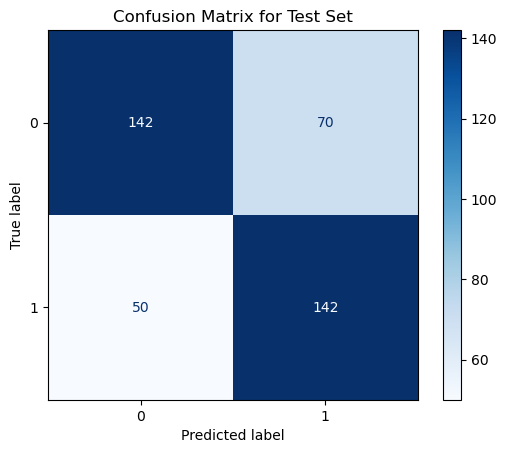

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate a confusion matrix to visualize the test predictions
cm_test = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Test Set')
plt.show()

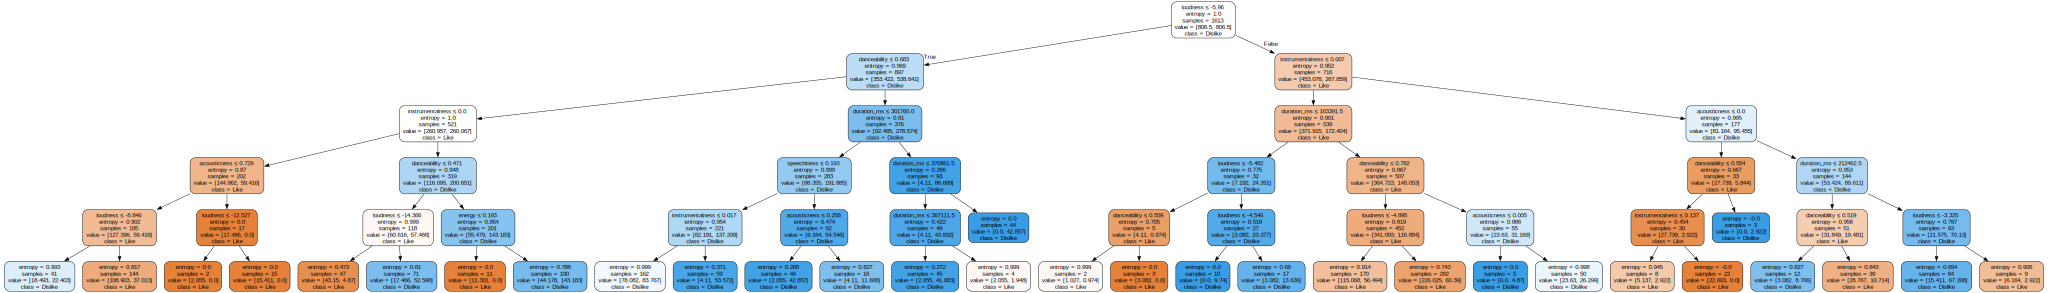

'decision_tree.pdf'

In [17]:
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz
from IPython.display import display

# Export the Decision Tree to DOT format
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=X_train.columns, 
                           class_names=['Like', 'Dislike'],
                           filled=True, rounded=True, special_characters=True)

# Visualize the Decision Tree using Graphviz
graph = graphviz.Source(dot_data)
display(graph)
graph.render("decision_tree")  # This will save the visualization as a PDF file
graph.view("decision_tree")    # This will open the PDF file using the default viewer